# Transfer Learning

<a target="_blank" href="https://colab.research.google.com/github/LuisAngelMendozaVelasco/TensorFlow-Advanced_Techniques_Specialization/blob/master/Advanced_Computer_Vision_with_TensorFlow/Week1/Labs/C3_W1_Lab_2_Transfer_Learning_CIFAR_10.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a>

In this notebook, you will perform transfer learning to train CIFAR-10 dataset on ResNet50 model available in Keras.

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras import datasets, applications, layers, Model

## Parameters

- Define the batch size
- Define the class (category) names

In [2]:
BATCH_SIZE = 32
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Define some functions that will help you to create some visualizations. (These will be used later)

In [16]:
# Utility to display a row of digits with their predictions
def display_images(digits, predictions, labels, title):
    n = 10

    indexes = np.random.choice(len(predictions), size=n)
    n_digits = digits[indexes]
    n_predictions = predictions[indexes]
    n_predictions = n_predictions.reshape((n,))
    n_labels = labels[indexes]

    fig = plt.figure(figsize=(20, 4))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])

    for i in range(10):
        ax = fig.add_subplot(1, 10, i + 1)
        class_index = n_predictions[i]

        plt.xlabel(classes[class_index])
        plt.xticks([])
        plt.yticks([])
        plt.imshow(n_digits[i])

# Utility to display training and validation curves
def plot_metrics(metric_name, title):
    sns.set_style("whitegrid")
    plt.title(title)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.xlabel("Epochs")
    plt.legend(["Training", "Validation"])
    sns.set_style("white")

## Loading and Preprocessing Data
[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset has 32 x 32 RGB images belonging to 10 classes. You will load the dataset from Keras.

In [4]:
(training_images, training_labels), (validation_images, validation_labels) = datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


### Visualize Dataset

Use the `display_image` to view some of the images and their class labels.

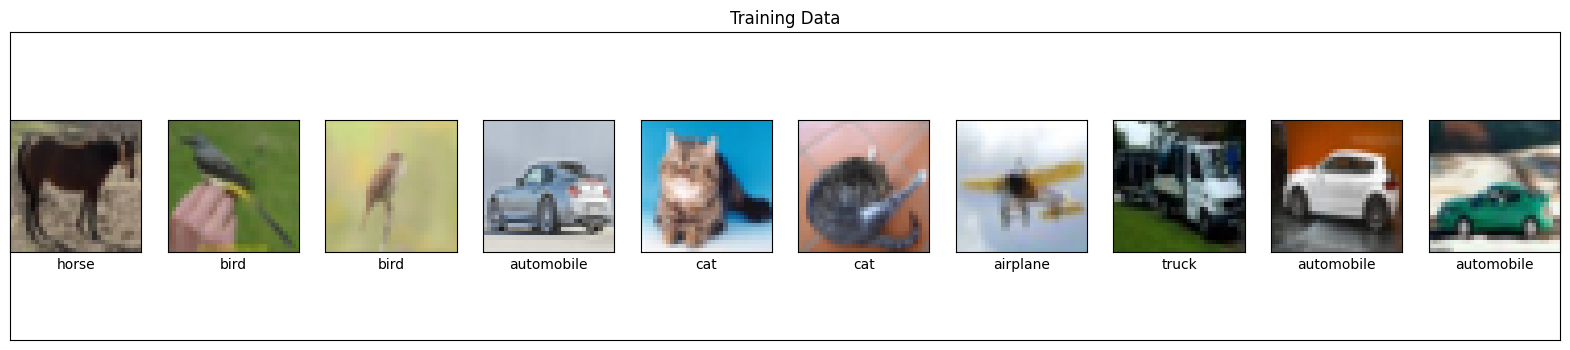

In [5]:
display_images(training_images, training_labels, training_labels, "Training Data")

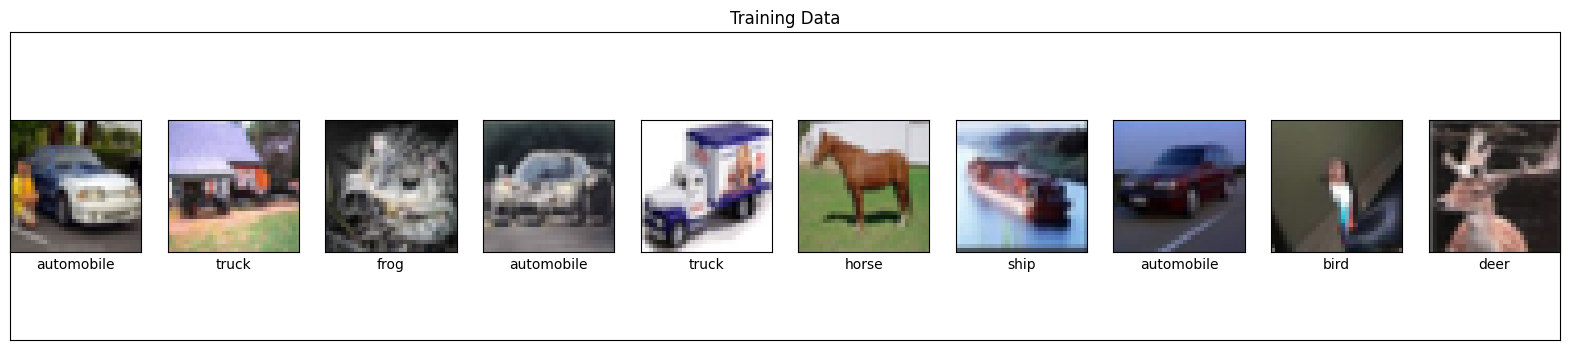

In [6]:
display_images(validation_images, validation_labels, validation_labels, "Training Data")

In [7]:
validation_images[0].astype('float32').shape

(32, 32, 3)

### Preprocess Dataset
Here, you'll perform normalization on images in training and validation set.
- You'll use the function [preprocess_input](https://github.com/keras-team/keras-applications/blob/master/keras_applications/resnet50.py) from the ResNet50 model in Keras.

In [8]:
def preprocess_image_input(input_images):
    input_images = input_images.astype('float32')
    output_ims = applications.resnet50.preprocess_input(input_images)

    return output_ims

In [9]:
train_X = preprocess_image_input(training_images)
valid_X = preprocess_image_input(validation_images)

## Define the Network
You will be performing transfer learning on **ResNet50** available in Keras.
- You'll load pre-trained **imagenet weights** to the model.
- You'll choose to retain all layers of **ResNet50** along with the final classification layers.

In [10]:
'''
Feature Extraction is performed by ResNet50 pretrained on imagenet weights.
Input size is 224 x 224.
'''
def feature_extractor(inputs):
    feature_extractor = applications.resnet.ResNet50(input_shape=(224, 224, 3),
                                                     include_top=False,
                                                     weights='imagenet')(inputs)

    return feature_extractor

'''
Defines final dense layers and subsequent softmax layer for classification.
'''
def classifier(inputs):
    x = layers.GlobalAveragePooling2D()(inputs)
    x = layers.Flatten()(x)
    x = layers.Dense(1024, activation="relu")(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dense(10, activation="softmax", name="classification")(x)

    return x

'''
Since input image size is (32 x 32), first upsample the image by factor of (7x7) to transform it to (224 x 224)
Connect the feature extraction and "classifier" layers to build the model.
'''
def final_model(inputs):
    resize = layers.UpSampling2D(size=(7, 7))(inputs)

    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

'''
Define the model and compile it.
Use Stochastic Gradient Descent as the optimizer.
Use Sparse Categorical CrossEntropy as the loss function.
'''
def define_compile_model():
    inputs = layers.Input(shape=(32, 32, 3))

    classification_output = final_model(inputs)
    model = Model(inputs=inputs, outputs=classification_output)

    model.compile(optimizer='SGD',
                  loss='sparse_categorical_crossentropy',
                  metrics = ['accuracy'])

    return model

model = define_compile_model()
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classification (Dense)               │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,215,818 (100.01 MB)

 Trainable params: 26,162,698 (99.80 MB)

 Non-trainable params: 53,120 (207.50 KB)

## Train the model

In [11]:
# This will take around 20 minutes to complete
EPOCHS = 4
history = model.fit(train_X, training_labels, epochs=EPOCHS, validation_data=(valid_X, validation_labels), batch_size=BATCH_SIZE)

Epoch 1/4
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 506s 299ms/step - accuracy: 0.7949 - loss: 0.6110 - val_accuracy: 0.9314 - val_loss: 0.2075
Epoch 2/4
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 460s 289ms/step - accuracy: 0.9673 - loss: 0.0975 - val_accuracy: 0.9456 - val_loss: 0.1557
Epoch 3/4
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 452s 289ms/step - accuracy: 0.9891 - loss: 0.0374 - val_accuracy: 0.9550 - val_loss: 0.1545
Epoch 4/4
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 495s 285ms/step - accuracy: 0.9934 - loss: 0.0213 - val_accuracy: 0.9523 - val_loss: 0.1698


## Evaluate the Model

Calculate the loss and accuracy metrics using the model's `.evaluate` function.

In [12]:
loss, accuracy = model.evaluate(valid_X, validation_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss:", loss)
print("Accuracy:", accuracy)

Loss: 0.16980955004692078
Accuracy: 0.9523000121116638


### Plot Loss and Accuracy Curves

Plot the loss (in blue) and validation loss (in green).

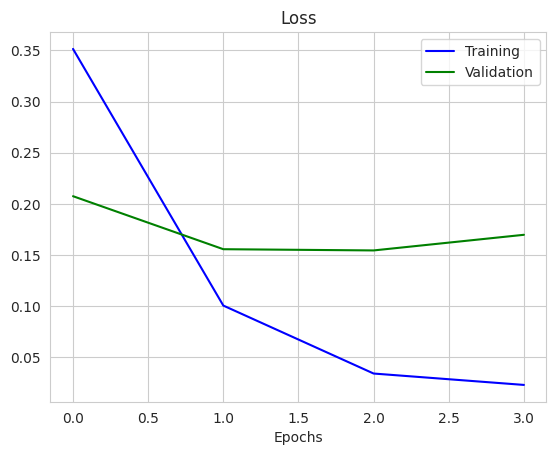

In [17]:
plot_metrics("loss", "Loss")

Plot the training accuracy (blue) as well as the validation accuracy (green).

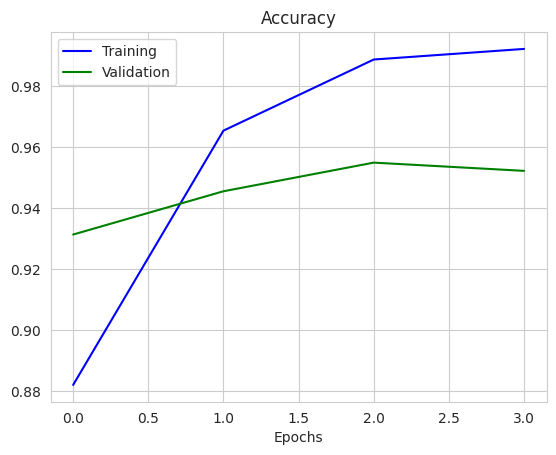

In [18]:
plot_metrics("accuracy", "Accuracy")

### Visualize predictions
You can take a look at the predictions on the validation set.

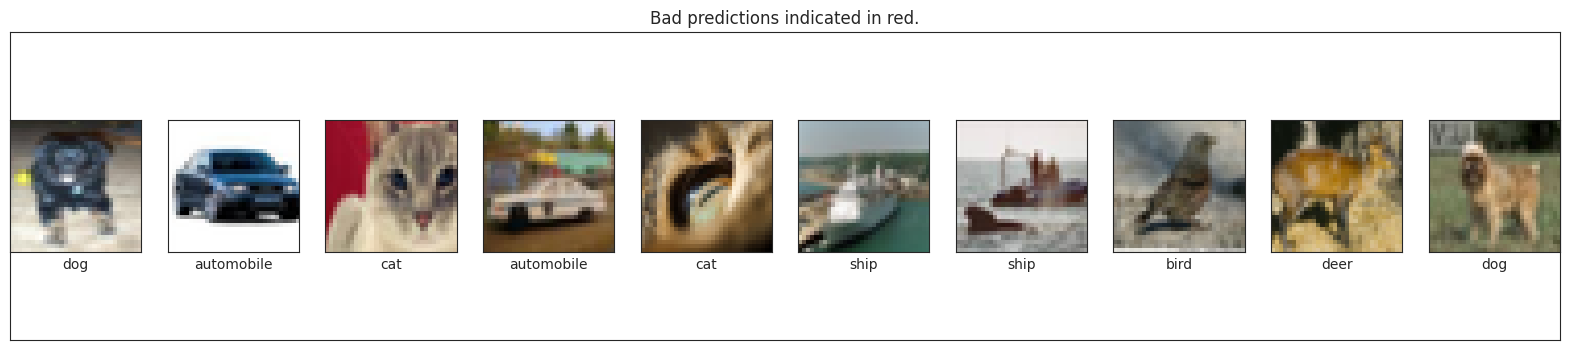

In [19]:
probabilities = model.predict(valid_X, batch_size=BATCH_SIZE, verbose=0)
probabilities = np.argmax(probabilities, axis=1)

display_images(validation_images, probabilities, validation_labels, "Bad predictions indicated in red.")